In [1]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [4]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 1

model_a = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [5]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 1000,
)

Epoch 1/1000
1/1 [==============================] - 0s 22ms/step - MSE: 15579832.0000
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - MSE: 15435949.0000
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - MSE: 15293834.0000
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - MSE: 15153514.0000
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - MSE: 15015011.0000
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - MSE: 14878346.0000
Epoch 7/1000
1/1 [==============================] - 0s 18ms/step - MSE: 14743532.0000
Epoch 8/1000
1/1 [==============================] - 0s 18ms/step - MSE: 14610576.0000
Epoch 9/1000
1/1 [==============================] - 0s 20ms/step - MSE: 14479479.0000
Epoch 10/1000
1/1 [==============================] - 0s 75ms/step - MSE: 14350236.0000
Epoch 11/1000
1/1 [==============================] - 0s 18ms/step - MSE: 14222828.0000
Epoch 12/1000
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step - MSE: 7667825.0000
Epoch 96/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7620500.5000
Epoch 97/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7573618.5000
Epoch 98/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7527169.5000
Epoch 99/1000
1/1 [==============================] - 0s 18ms/step - MSE: 7481150.0000
Epoch 100/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7435553.5000
Epoch 101/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7390376.0000
Epoch 102/1000
1/1 [==============================] - 0s 18ms/step - MSE: 7345611.0000
Epoch 103/1000
1/1 [==============================] - 0s 18ms/step - MSE: 7301255.0000
Epoch 104/1000
1/1 [==============================] - 0s 17ms/step - MSE: 7257301.5000
Epoch 105/1000
1/1 [==============================] - 0s 18ms/step - MSE: 7213746.5000
Epoch 106/1000
1/1 [==============================] - 0s 18ms/

1/1 [==============================] - 0s 18ms/step - MSE: 4610729.0000
Epoch 190/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4589047.5000
Epoch 191/1000
1/1 [==============================] - 0s 18ms/step - MSE: 4567527.0000
Epoch 192/1000
1/1 [==============================] - 0s 18ms/step - MSE: 4546167.0000
Epoch 193/1000
1/1 [==============================] - 0s 18ms/step - MSE: 4524963.5000
Epoch 194/1000
1/1 [==============================] - 0s 18ms/step - MSE: 4503917.5000
Epoch 195/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4483026.5000
Epoch 196/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4462287.5000
Epoch 197/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4441702.0000
Epoch 198/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4421266.0000
Epoch 199/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4400980.0000
Epoch 200/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - MSE: 3115151.7500
Epoch 284/1000
1/1 [==============================] - 0s 18ms/step - MSE: 3103734.0000
Epoch 285/1000
1/1 [==============================] - 0s 18ms/step - MSE: 3092387.2500
Epoch 286/1000
1/1 [==============================] - 0s 18ms/step - MSE: 3081110.2500
Epoch 287/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3069904.0000
Epoch 288/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3058767.0000
Epoch 289/1000
1/1 [==============================] - 0s 18ms/step - MSE: 3047698.2500
Epoch 290/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3036697.7500
Epoch 291/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3025765.5000
Epoch 292/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3014899.7500
Epoch 293/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3004100.7500
Epoch 294/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - MSE: 2289902.0000
Epoch 378/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2283242.7500
Epoch 379/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2276618.2500
Epoch 380/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2270027.7500
Epoch 381/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2263471.0000
Epoch 382/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2256948.7500
Epoch 383/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2250459.2500
Epoch 384/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2244003.2500
Epoch 385/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2237580.5000
Epoch 386/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2231191.5000
Epoch 387/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2224836.0000
Epoch 388/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - MSE: 1786864.5000
Epoch 472/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1782591.1250
Epoch 473/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1778335.8750
Epoch 474/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1774098.3750
Epoch 475/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1769879.5000
Epoch 476/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1765677.8750
Epoch 477/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1761494.0000
Epoch 478/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1757328.0000
Epoch 479/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1753179.3750
Epoch 480/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1749048.0000
Epoch 481/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1744933.8750
Epoch 482/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - MSE: 1452078.2500
Epoch 566/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1449129.5000
Epoch 567/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1446191.6250
Epoch 568/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1443264.6250
Epoch 569/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1440348.3750
Epoch 570/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1437442.6250
Epoch 571/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1434547.5000
Epoch 572/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1431663.1250
Epoch 573/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1428789.6250
Epoch 574/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1425926.7500
Epoch 575/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1423074.3750
Epoch 576/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - MSE: 1218741.1250
Epoch 659/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1216626.6250
Epoch 660/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1214520.1250
Epoch 661/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1212421.0000
Epoch 662/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1210329.0000
Epoch 663/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1208244.5000
Epoch 664/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1206167.1250
Epoch 665/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1204096.8750
Epoch 666/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1202034.0000
Epoch 667/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1199978.2500
Epoch 668/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1197929.5000
Epoch 669/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - MSE: 1049020.0000
Epoch 753/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1047497.6875
Epoch 754/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1045980.5000
Epoch 755/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1044468.6250
Epoch 756/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1042961.9375
Epoch 757/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1041460.6250
Epoch 758/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1039964.4375
Epoch 759/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1038473.3125
Epoch 760/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1036987.6250
Epoch 761/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1035507.1250
Epoch 762/1000
1/1 [==============================] - 0s 18ms/step - MSE: 1034031.6250
Epoch 763/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - MSE: 926015.6875
Epoch 848/1000
1/1 [==============================] - 0s 19ms/step - MSE: 924928.7500
Epoch 849/1000
1/1 [==============================] - 0s 19ms/step - MSE: 923845.4375
Epoch 850/1000
1/1 [==============================] - 0s 19ms/step - MSE: 922766.1250
Epoch 851/1000
1/1 [==============================] - 0s 19ms/step - MSE: 921690.4375
Epoch 852/1000
1/1 [==============================] - 0s 19ms/step - MSE: 920618.9375
Epoch 853/1000
1/1 [==============================] - 0s 19ms/step - MSE: 919552.5625
Epoch 854/1000
1/1 [==============================] - 0s 19ms/step - MSE: 918490.1250
Epoch 855/1000
1/1 [==============================] - 0s 19ms/step - MSE: 917431.3125
Epoch 856/1000
1/1 [==============================] - 0s 19ms/step - MSE: 916376.2500
Epoch 857/1000
1/1 [==============================] - 0s 19ms/step - MSE: 915325.2500
Epoch 858/1000
1/1 [==============================] - 0s 18ms/step - 

1/1 [==============================] - 0s 18ms/step - MSE: 838615.3125
Epoch 943/1000
1/1 [==============================] - 0s 18ms/step - MSE: 837847.9375
Epoch 944/1000
1/1 [==============================] - 0s 18ms/step - MSE: 837083.4375
Epoch 945/1000
1/1 [==============================] - 0s 19ms/step - MSE: 836321.6250
Epoch 946/1000
1/1 [==============================] - 0s 18ms/step - MSE: 835562.6250
Epoch 947/1000
1/1 [==============================] - 0s 19ms/step - MSE: 834806.1875
Epoch 948/1000
1/1 [==============================] - 0s 18ms/step - MSE: 834052.6875
Epoch 949/1000
1/1 [==============================] - 0s 19ms/step - MSE: 833301.8750
Epoch 950/1000
1/1 [==============================] - 0s 18ms/step - MSE: 832553.6875
Epoch 951/1000
1/1 [==============================] - 0s 19ms/step - MSE: 831808.1875
Epoch 952/1000
1/1 [==============================] - 0s 18ms/step - MSE: 831065.3750
Epoch 953/1000
1/1 [==============================] - 0s 19ms/step - 

In [6]:
#Initialize model with filter bank [1,0,0,0,...], [0,1,0,0,...], [0,0,1,0,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if i == j else 0. for j in range(30)] for i in range(30)]
lr = 1

model_b = Model(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 0.000001,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_B_PATH = "model_b.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_B_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_b.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [7]:
#Training
hist = model_b.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 1000,
)

Epoch 1/1000
1/1 [==============================] - 0s 20ms/step - MSE: 15582257.0000
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - MSE: 15438350.0000
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - MSE: 15296213.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - MSE: 15155867.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - MSE: 15017342.0000
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - MSE: 14880656.0000
Epoch 7/1000
1/1 [==============================] - 0s 19ms/step - MSE: 14745821.0000
Epoch 8/1000
1/1 [==============================] - 0s 20ms/step - MSE: 14612841.0000
Epoch 9/1000
1/1 [==============================] - 0s 21ms/step - MSE: 14481721.0000
Epoch 10/1000
1/1 [==============================] - 0s 23ms/step - MSE: 14352454.0000
Epoch 11/1000
1/1 [==============================] - 0s 21ms/step - MSE: 14225027.0000
Epoch 12/1000
1/1 [==============================] -

1/1 [==============================] - 0s 25ms/step - MSE: 7683280.0000
Epoch 96/1000
1/1 [==============================] - 0s 22ms/step - MSE: 7636460.0000
Epoch 97/1000
1/1 [==============================] - 0s 20ms/step - MSE: 7590091.5000
Epoch 98/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7544168.0000
Epoch 99/1000
1/1 [==============================] - 0s 20ms/step - MSE: 7498686.0000
Epoch 100/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7453638.5000
Epoch 101/1000
1/1 [==============================] - 0s 21ms/step - MSE: 7409021.0000
Epoch 102/1000
1/1 [==============================] - 0s 21ms/step - MSE: 7364828.0000
Epoch 103/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7321055.5000
Epoch 104/1000
1/1 [==============================] - 0s 20ms/step - MSE: 7277697.5000
Epoch 105/1000
1/1 [==============================] - 0s 19ms/step - MSE: 7234749.5000
Epoch 106/1000
1/1 [==============================] - 0s 19ms/

1/1 [==============================] - 0s 19ms/step - MSE: 4724884.5000
Epoch 190/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4704789.0000
Epoch 191/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4684865.5000
Epoch 192/1000
1/1 [==============================] - 0s 18ms/step - MSE: 4665111.0000
Epoch 193/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4645525.5000
Epoch 194/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4626106.5000
Epoch 195/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4606852.0000
Epoch 196/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4587762.0000
Epoch 197/1000
1/1 [==============================] - 0s 21ms/step - MSE: 4568834.0000
Epoch 198/1000
1/1 [==============================] - 0s 25ms/step - MSE: 4550067.5000
Epoch 199/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4531459.5000
Epoch 200/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 20ms/step - MSE: 3418110.7500
Epoch 284/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3409053.2500
Epoch 285/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3400072.5000
Epoch 286/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3391168.0000
Epoch 287/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3382338.5000
Epoch 288/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3373583.5000
Epoch 289/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3364902.7500
Epoch 290/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3356294.7500
Epoch 291/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3347761.0000
Epoch 292/1000
1/1 [==============================] - 0s 19ms/step - MSE: 3339300.0000
Epoch 293/1000
1/1 [==============================] - 0s 20ms/step - MSE: 3330910.2500
Epoch 294/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 2830709.2500
Epoch 378/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2826678.7500
Epoch 379/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2822683.7500
Epoch 380/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2818722.7500
Epoch 381/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2814797.2500
Epoch 382/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2810906.5000
Epoch 383/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2807049.2500
Epoch 384/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2803226.0000
Epoch 385/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2799436.2500
Epoch 386/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2795680.0000
Epoch 387/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2791956.5000
Epoch 388/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 20ms/step - MSE: 2573566.7500
Epoch 472/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2571853.7500
Epoch 473/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2570157.5000
Epoch 474/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2568477.0000
Epoch 475/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2566812.2500
Epoch 476/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2565163.5000
Epoch 477/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2563530.2500
Epoch 478/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2561912.2500
Epoch 479/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2560310.0000
Epoch 480/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2558722.7500
Epoch 481/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2557150.7500
Epoch 482/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 20ms/step - MSE: 2467668.0000
Epoch 566/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2466995.2500
Epoch 567/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2466328.5000
Epoch 568/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2465669.2500
Epoch 569/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2465017.0000
Epoch 570/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2464371.0000
Epoch 571/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2463731.7500
Epoch 572/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2463099.2500
Epoch 573/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2462473.2500
Epoch 574/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2461854.2500
Epoch 575/1000
1/1 [==============================] - 0s 22ms/step - MSE: 2461241.0000
Epoch 576/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 2427389.2500
Epoch 660/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2427144.5000
Epoch 661/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2426902.0000
Epoch 662/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2426662.2500
Epoch 663/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2426424.7500
Epoch 664/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2426190.2500
Epoch 665/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2425958.5000
Epoch 666/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2425729.5000
Epoch 667/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2425502.5000
Epoch 668/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2425278.2500
Epoch 669/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2425056.5000
Epoch 670/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 21ms/step - MSE: 2413026.7500
Epoch 754/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2412940.5000
Epoch 755/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2412855.7500
Epoch 756/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2412772.0000
Epoch 757/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2412688.7500
Epoch 758/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2412606.5000
Epoch 759/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2412525.5000
Epoch 760/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2412445.0000
Epoch 761/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2412365.2500
Epoch 762/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2412286.7500
Epoch 763/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2412209.0000
Epoch 764/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - MSE: 2407972.2500
Epoch 848/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407941.7500
Epoch 849/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407911.7500
Epoch 850/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407881.7500
Epoch 851/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407852.5000
Epoch 852/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407823.2500
Epoch 853/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2407794.5000
Epoch 854/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2407766.0000
Epoch 855/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2407738.0000
Epoch 856/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2407710.5000
Epoch 857/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2407682.5000
Epoch 858/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 21ms/step - MSE: 2406153.5000
Epoch 942/1000
1/1 [==============================] - 0s 23ms/step - MSE: 2406142.0000
Epoch 943/1000
1/1 [==============================] - 0s 22ms/step - MSE: 2406130.5000
Epoch 944/1000
1/1 [==============================] - 0s 31ms/step - MSE: 2406119.0000
Epoch 945/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2406108.0000
Epoch 946/1000
1/1 [==============================] - 0s 23ms/step - MSE: 2406097.0000
Epoch 947/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2406085.7500
Epoch 948/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2406074.7500
Epoch 949/1000
1/1 [==============================] - 0s 21ms/step - MSE: 2406064.2500
Epoch 950/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2406053.5000
Epoch 951/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2406043.0000
Epoch 952/1000
1/1 [==============================] - 0s 2

In [8]:
#Initialize model with filter bank [1,1,0,0,...], [0,1,1,0,...], [0,0,1,1,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if (j == i or j==(i+1)) else 0. for j in range(30)] for i in range(29)]
lr = 1

model_c = Model(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 0.000001,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_C_PATH = "model_c.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_C_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_c.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [9]:
#Training
hist = model_c.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 1000,
)

Epoch 1/1000
1/1 [==============================] - 0s 21ms/step - MSE: 15583368.0000
Epoch 2/1000
1/1 [==============================] - 0s 19ms/step - MSE: 15306354.0000
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - MSE: 15035984.0000
Epoch 4/1000
1/1 [==============================] - 0s 19ms/step - MSE: 14772342.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - MSE: 14515458.0000
Epoch 6/1000
1/1 [==============================] - 0s 20ms/step - MSE: 14265306.0000
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - MSE: 14021787.0000
Epoch 8/1000
1/1 [==============================] - 0s 19ms/step - MSE: 13784735.0000
Epoch 9/1000
1/1 [==============================] - 0s 19ms/step - MSE: 13553918.0000
Epoch 10/1000
1/1 [==============================] - 0s 19ms/step - MSE: 13329066.0000
Epoch 11/1000
1/1 [==============================] - 0s 20ms/step - MSE: 13109884.0000
Epoch 12/1000
1/1 [==============================] -

1/1 [==============================] - 0s 20ms/step - MSE: 4651561.5000
Epoch 97/1000
1/1 [==============================] - 0s 21ms/step - MSE: 4610413.5000
Epoch 98/1000
1/1 [==============================] - 0s 21ms/step - MSE: 4569908.5000
Epoch 99/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4530035.0000
Epoch 100/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4490779.5000
Epoch 101/1000
1/1 [==============================] - 0s 19ms/step - MSE: 4452131.5000
Epoch 102/1000
1/1 [==============================] - 0s 20ms/step - MSE: 4414079.5000
Epoch 103/1000
1/1 [==============================] - 0s 22ms/step - MSE: 4376613.5000
Epoch 104/1000
1/1 [==============================] - 0s 22ms/step - MSE: 4339721.0000
Epoch 105/1000
1/1 [==============================] - 0s 22ms/step - MSE: 4303392.5000
Epoch 106/1000
1/1 [==============================] - 0s 21ms/step - MSE: 4267617.5000
Epoch 107/1000
1/1 [==============================] - 0s 20ms

1/1 [==============================] - 0s 20ms/step - MSE: 2545109.5000
Epoch 191/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2534324.7500
Epoch 192/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2523681.2500
Epoch 193/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2513176.0000
Epoch 194/1000
1/1 [==============================] - 0s 18ms/step - MSE: 2502806.7500
Epoch 195/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2492572.0000
Epoch 196/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2482470.2500
Epoch 197/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2472498.5000
Epoch 198/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2462655.7500
Epoch 199/1000
1/1 [==============================] - 0s 19ms/step - MSE: 2452939.7500
Epoch 200/1000
1/1 [==============================] - 0s 20ms/step - MSE: 2443350.7500
Epoch 201/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 20ms/step - MSE: 1952022.5000
Epoch 285/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1948773.7500
Epoch 286/1000
1/1 [==============================] - 0s 22ms/step - MSE: 1945567.5000
Epoch 287/1000
1/1 [==============================] - 0s 22ms/step - MSE: 1942402.7500
Epoch 288/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1939279.0000
Epoch 289/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1936195.2500
Epoch 290/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1933151.7500
Epoch 291/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1930147.5000
Epoch 292/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1927182.2500
Epoch 293/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1924255.2500
Epoch 294/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1921366.3750
Epoch 295/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 1777011.7500
Epoch 379/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1776112.1250
Epoch 380/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1775225.3750
Epoch 381/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1774351.3750
Epoch 382/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1773489.5000
Epoch 383/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1772639.7500
Epoch 384/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1771802.3750
Epoch 385/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1770977.1250
Epoch 386/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1770163.0000
Epoch 387/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1769360.8750
Epoch 388/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1768570.3750
Epoch 389/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 1730445.8750
Epoch 473/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1730215.1250
Epoch 474/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1729987.5000
Epoch 475/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1729763.2500
Epoch 476/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1729542.1250
Epoch 477/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1729323.8750
Epoch 478/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1729108.8750
Epoch 479/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1728897.1250
Epoch 480/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1728688.0000
Epoch 481/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1728482.0000
Epoch 482/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1728278.6250
Epoch 483/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 20ms/step - MSE: 1718114.1250
Epoch 567/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1718047.7500
Epoch 568/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1717982.1250
Epoch 569/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1717917.1250
Epoch 570/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1717853.3750
Epoch 571/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1717790.0000
Epoch 572/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1717727.6250
Epoch 573/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1717666.0000
Epoch 574/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1717604.7500
Epoch 575/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1717544.2500
Epoch 576/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1717485.0000
Epoch 577/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 1714245.3750
Epoch 661/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714221.6250
Epoch 662/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714198.0000
Epoch 663/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714174.5000
Epoch 664/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1714151.5000
Epoch 665/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1714128.6250
Epoch 666/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1714105.6250
Epoch 667/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1714083.1250
Epoch 668/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714060.5000
Epoch 669/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714038.7500
Epoch 670/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1714016.6250
Epoch 671/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 19ms/step - MSE: 1712696.6250
Epoch 755/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712685.8750
Epoch 756/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712674.8750
Epoch 757/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712664.1250
Epoch 758/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712653.7500
Epoch 759/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1712643.0000
Epoch 760/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712632.3750
Epoch 761/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712622.1250
Epoch 762/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1712611.7500
Epoch 763/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1712601.3750
Epoch 764/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1712591.1250
Epoch 765/1000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 20ms/step - MSE: 1711979.0000
Epoch 849/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1711973.7500
Epoch 850/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711968.7500
Epoch 851/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711963.6250
Epoch 852/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711958.7500
Epoch 853/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711953.7500
Epoch 854/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1711948.5000
Epoch 855/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711943.3750
Epoch 856/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711938.7500
Epoch 857/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711933.5000
Epoch 858/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711928.8750
Epoch 859/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 20ms/step - MSE: 1711596.5000
Epoch 943/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711593.3750
Epoch 944/1000
1/1 [==============================] - 0s 22ms/step - MSE: 1711590.3750
Epoch 945/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711587.1250
Epoch 946/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711584.1250
Epoch 947/1000
1/1 [==============================] - 0s 19ms/step - MSE: 1711581.1250
Epoch 948/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711578.1250
Epoch 949/1000
1/1 [==============================] - 0s 22ms/step - MSE: 1711575.2500
Epoch 950/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711572.2500
Epoch 951/1000
1/1 [==============================] - 0s 20ms/step - MSE: 1711569.2500
Epoch 952/1000
1/1 [==============================] - 0s 21ms/step - MSE: 1711566.5000
Epoch 953/1000
1/1 [==============================] - 0s 2

In [10]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    stacked_filter_bank = model.conv_layers[i].stacked_filter_bank
    weights = model.conv_layers[i].kernel
    kernel = tf.reduce_sum(stacked_filter_bank*weights,axis=0)
    kernel = tf.squeeze(kernel)
    return kernel

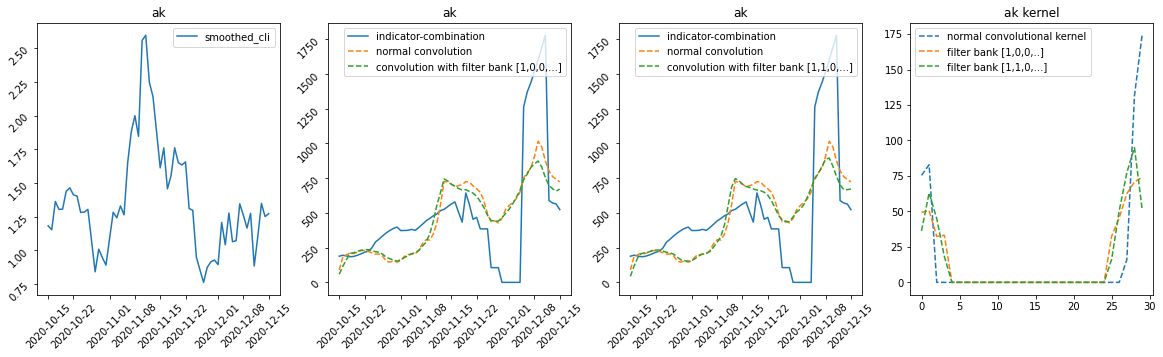

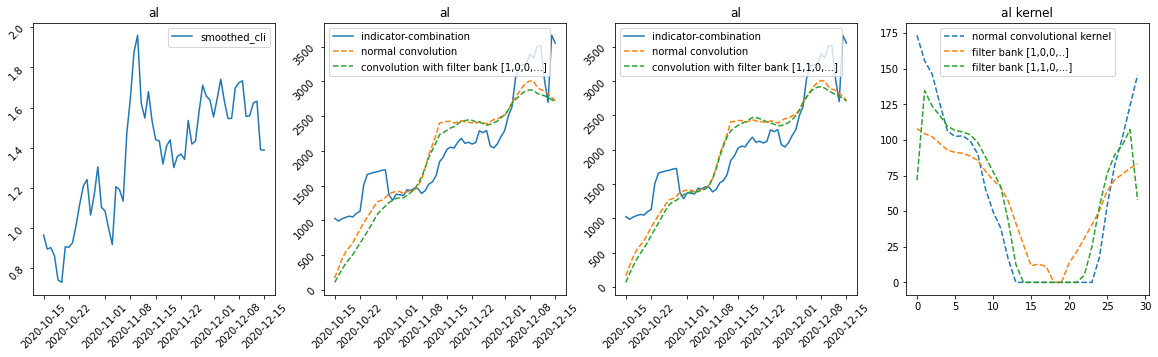

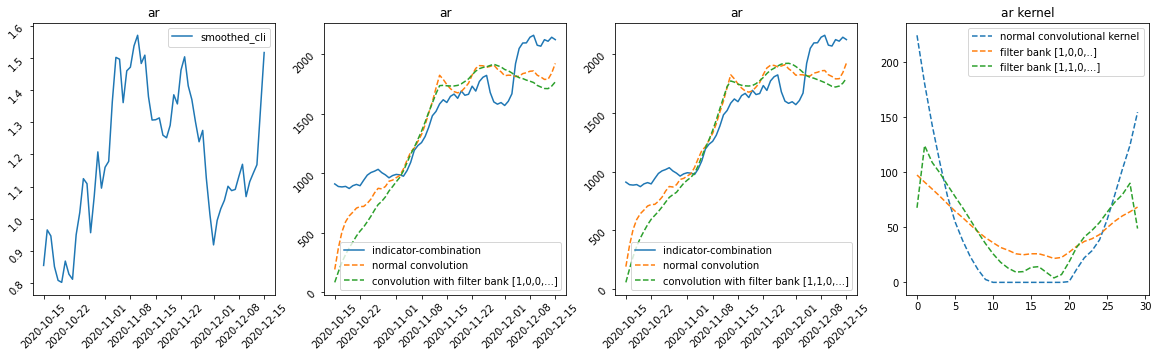

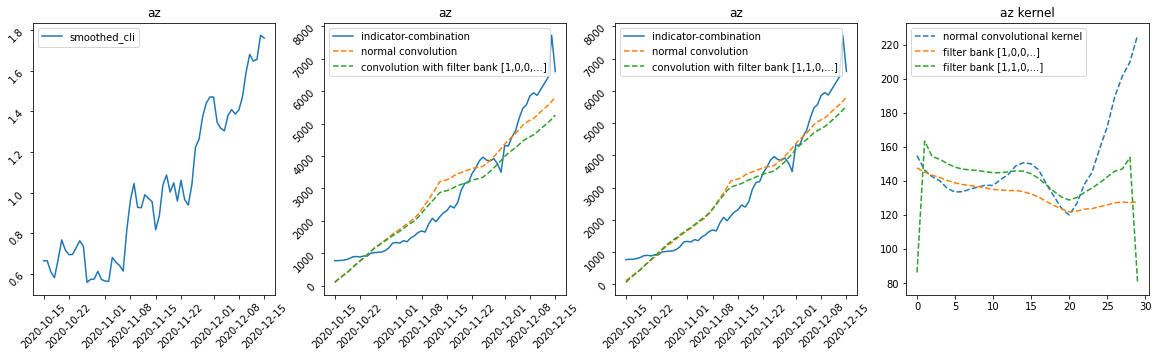

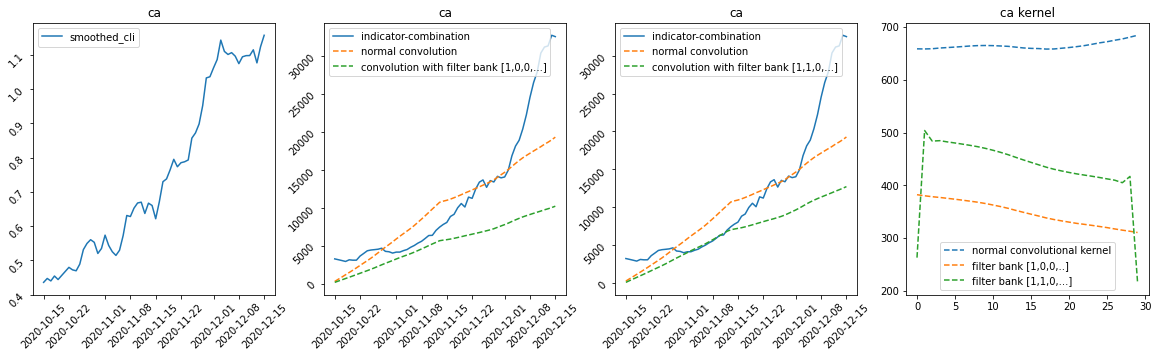

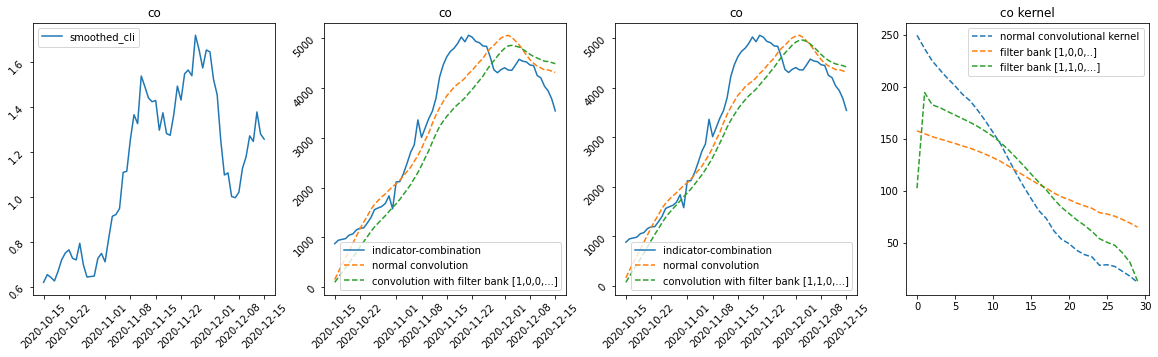

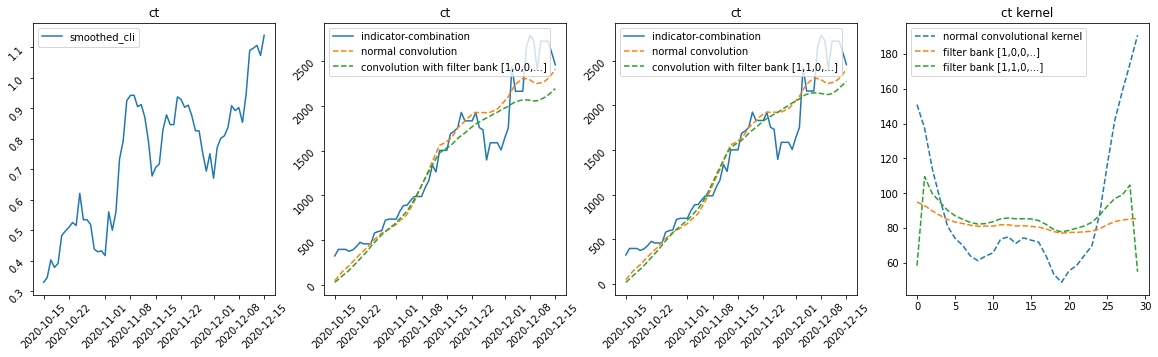

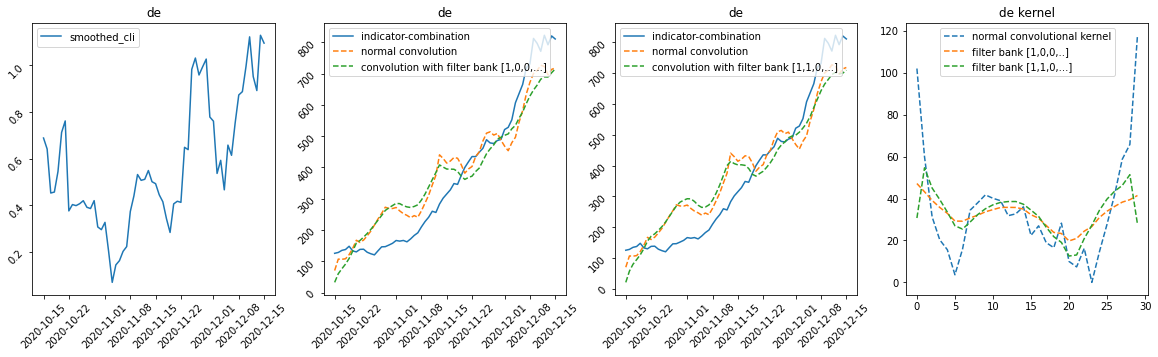

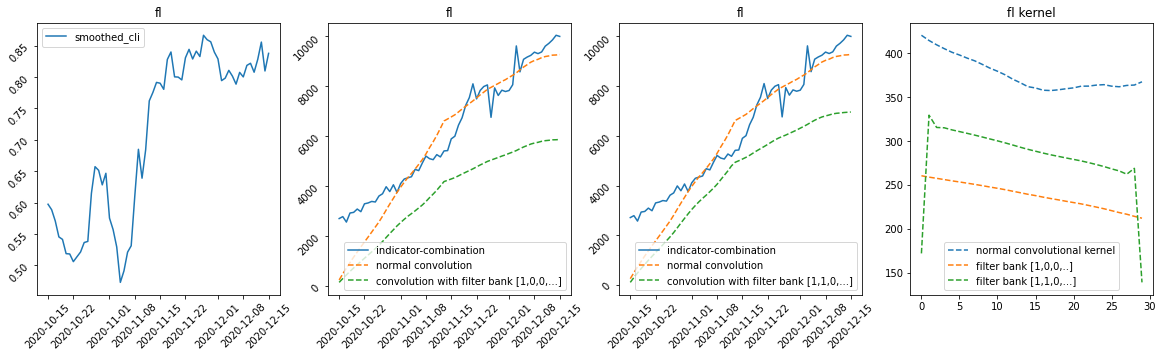

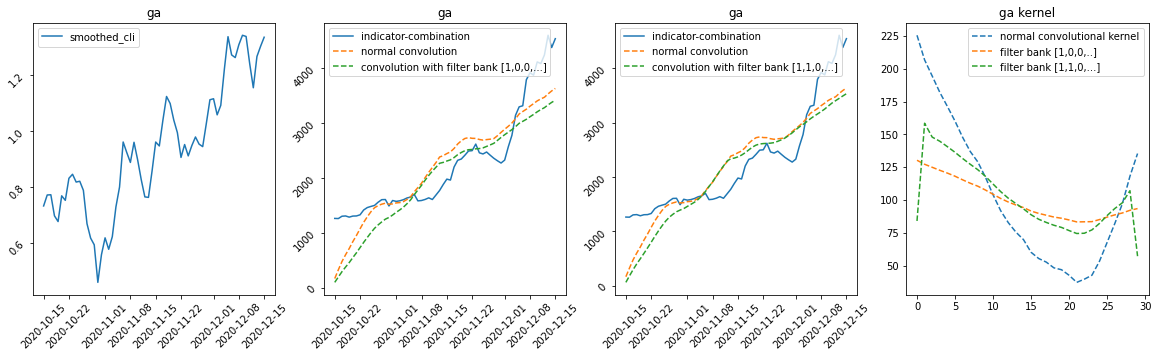

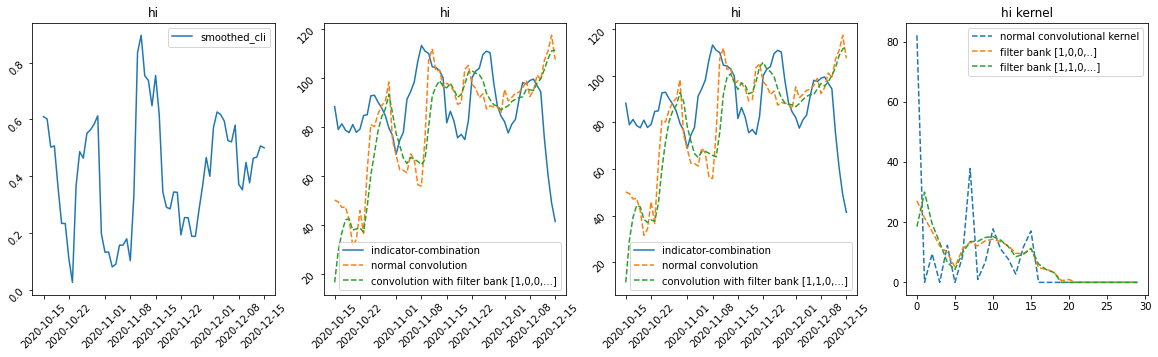

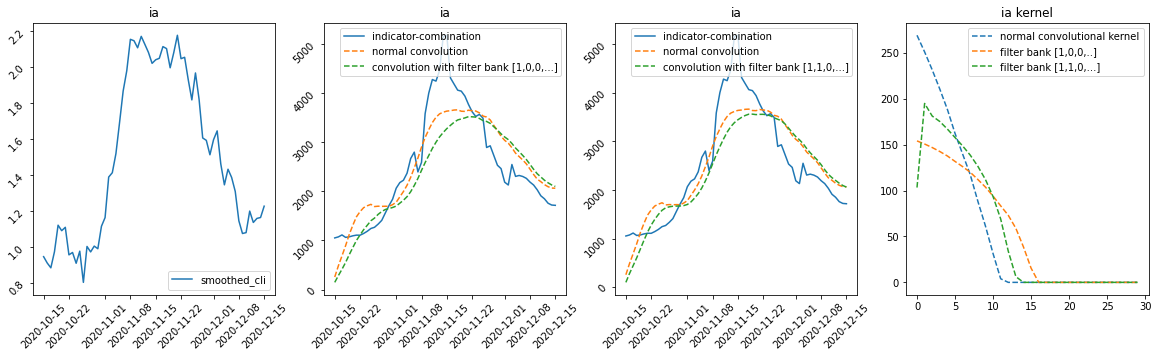

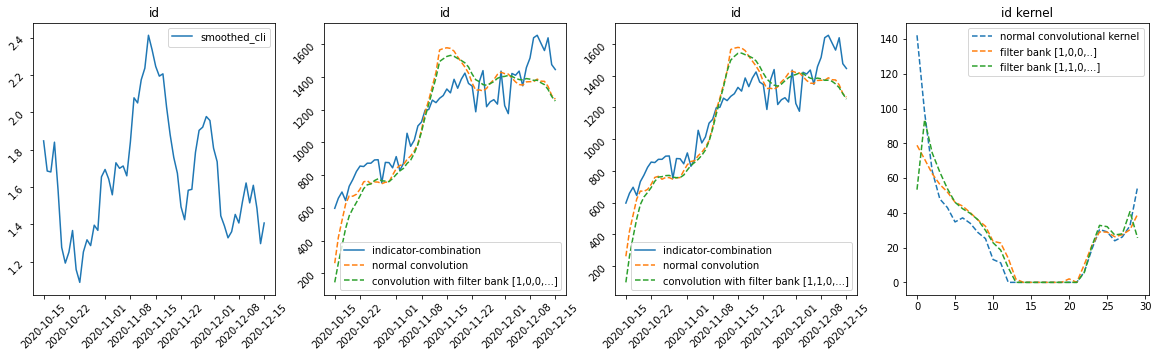

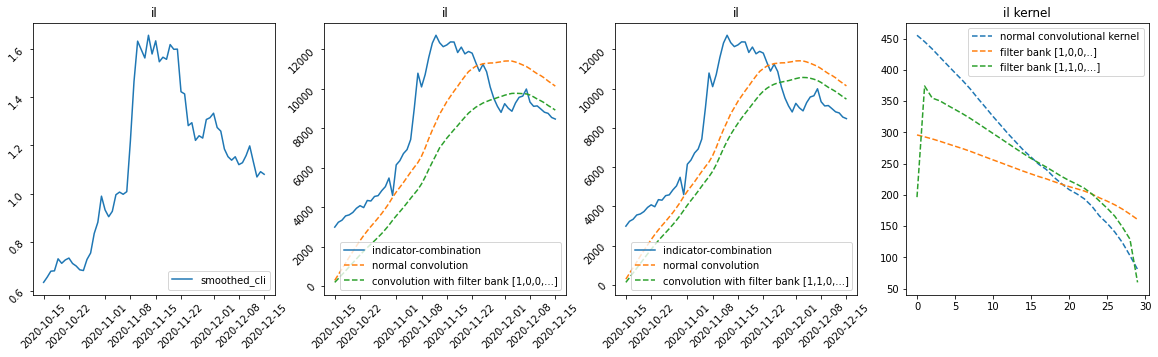

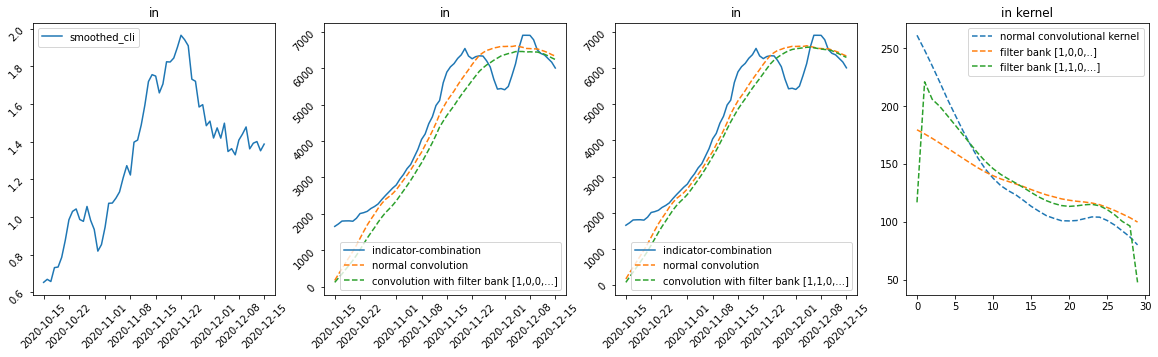

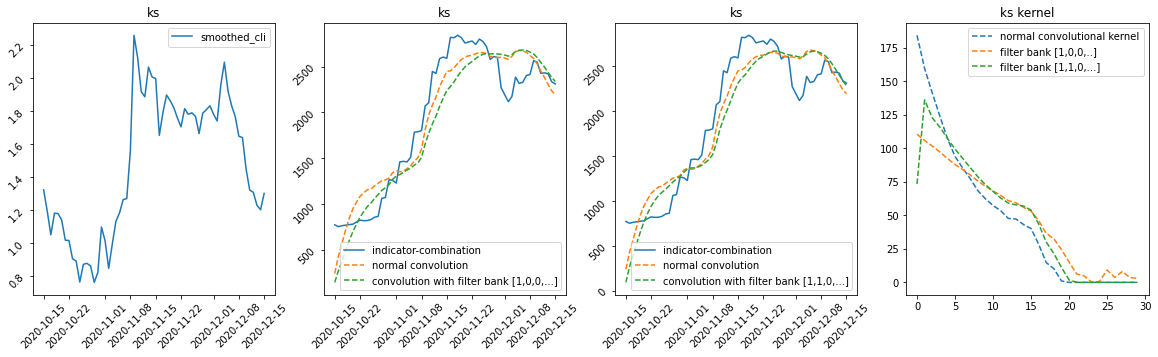

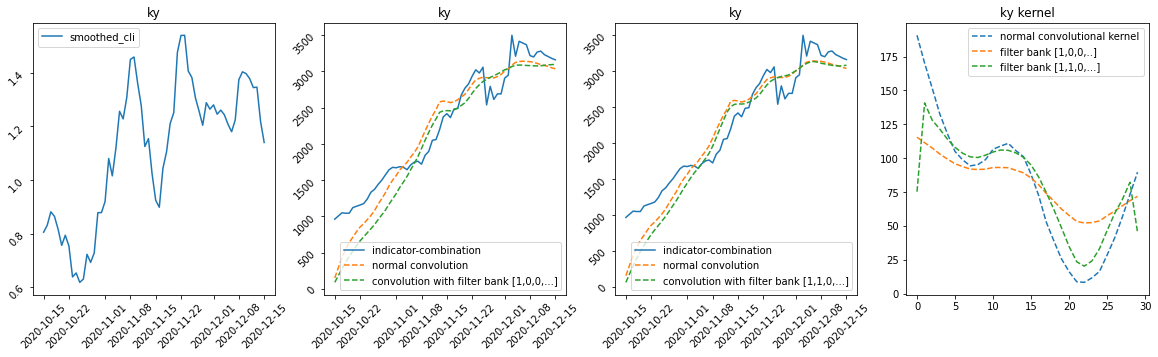

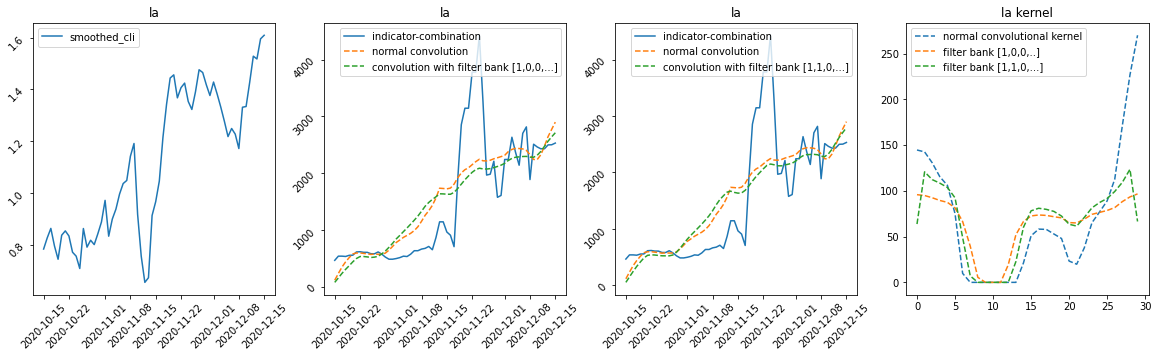

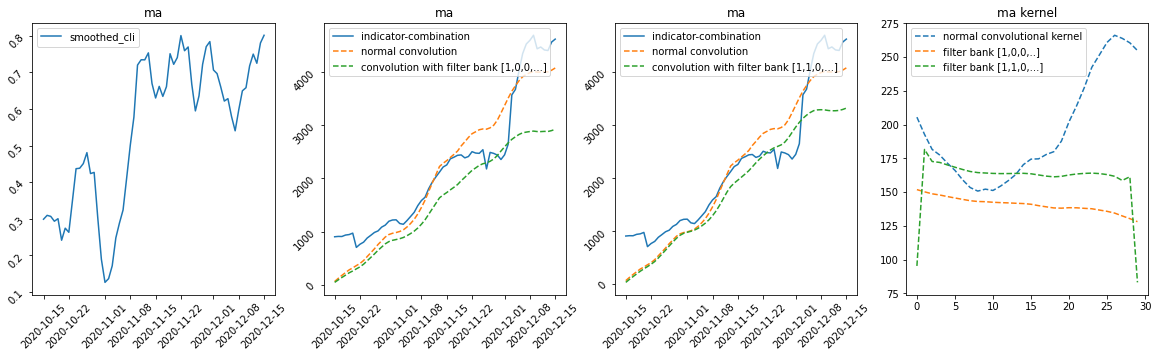

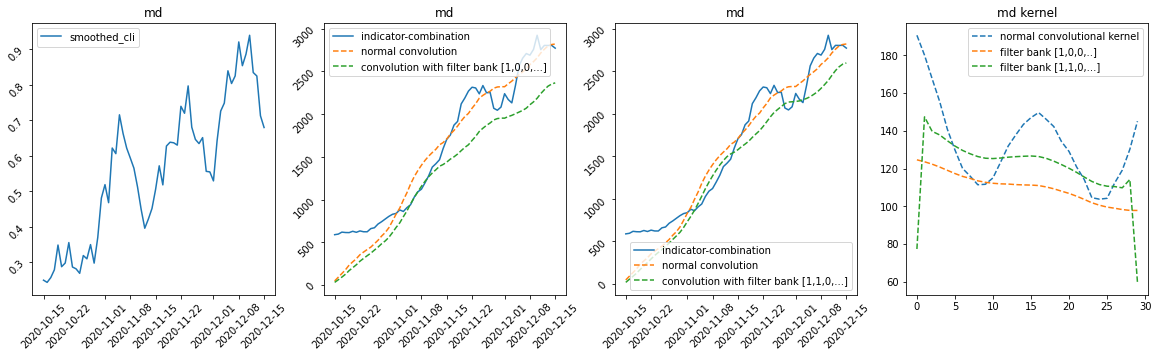

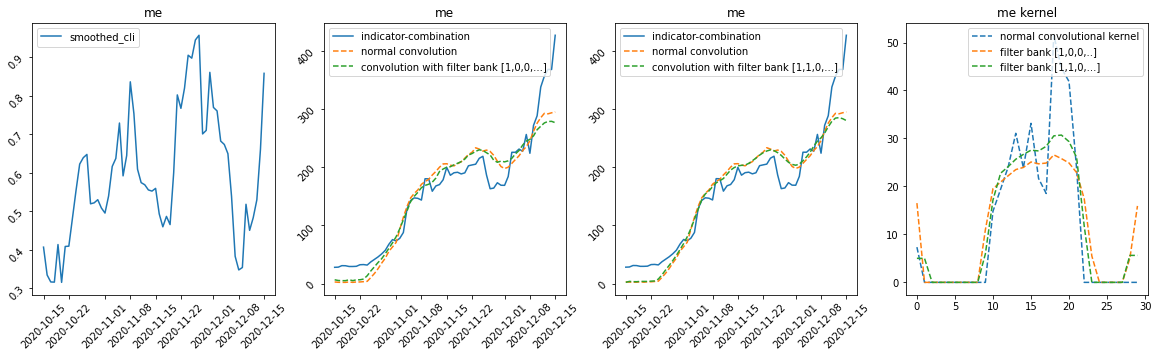

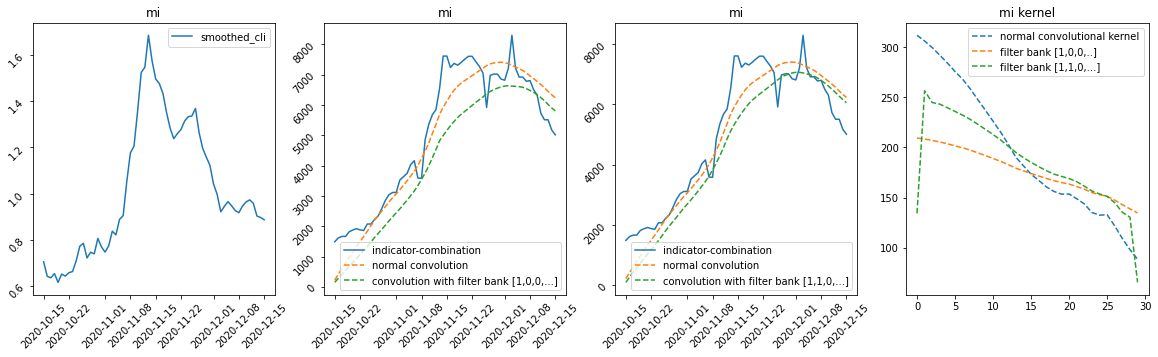

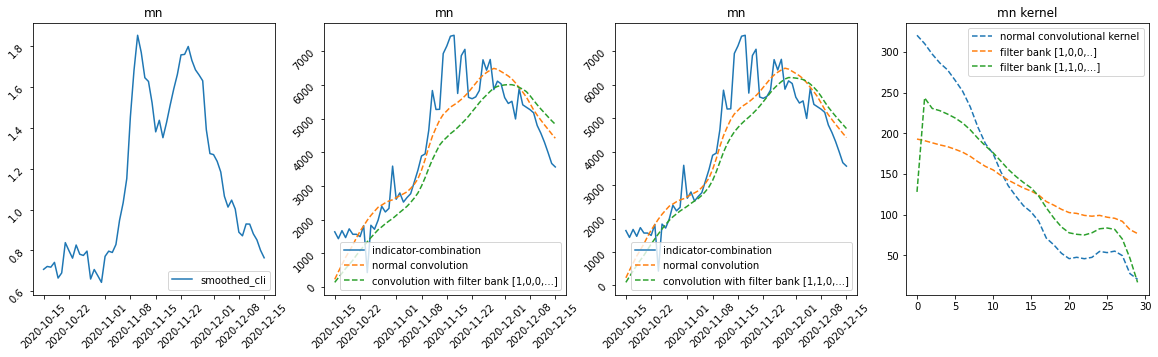

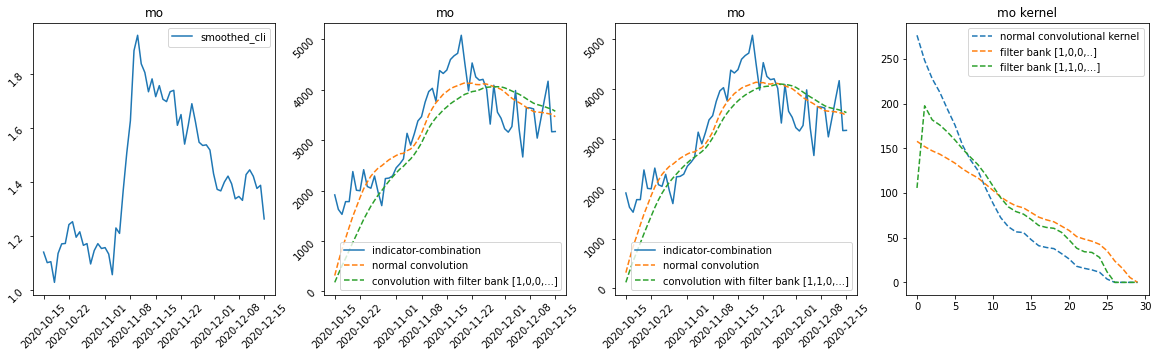

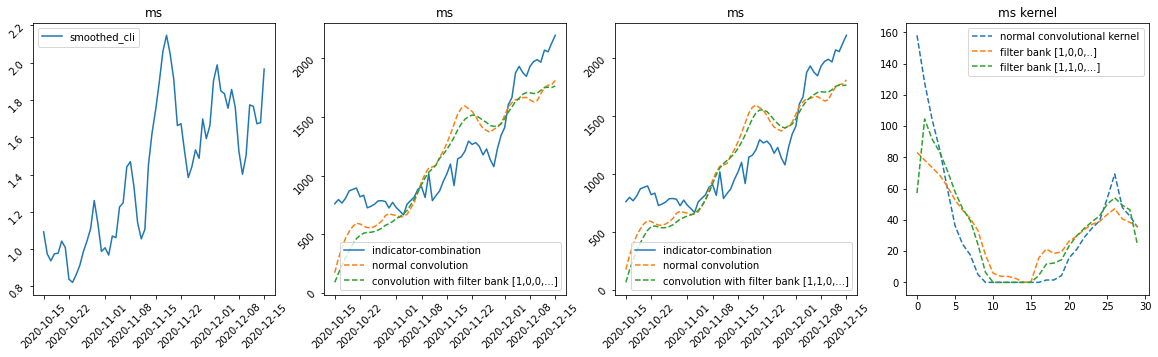

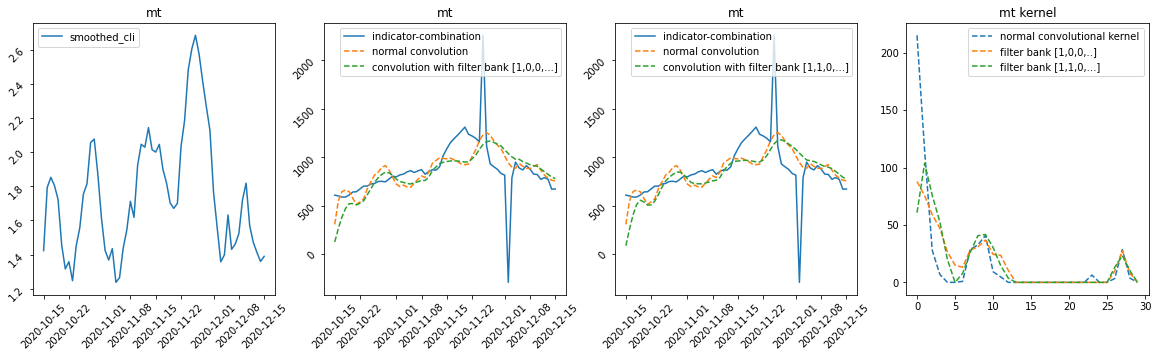

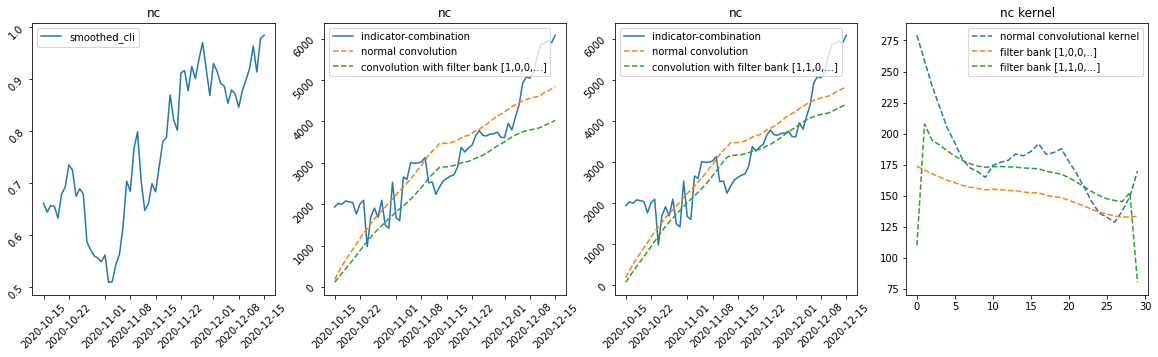

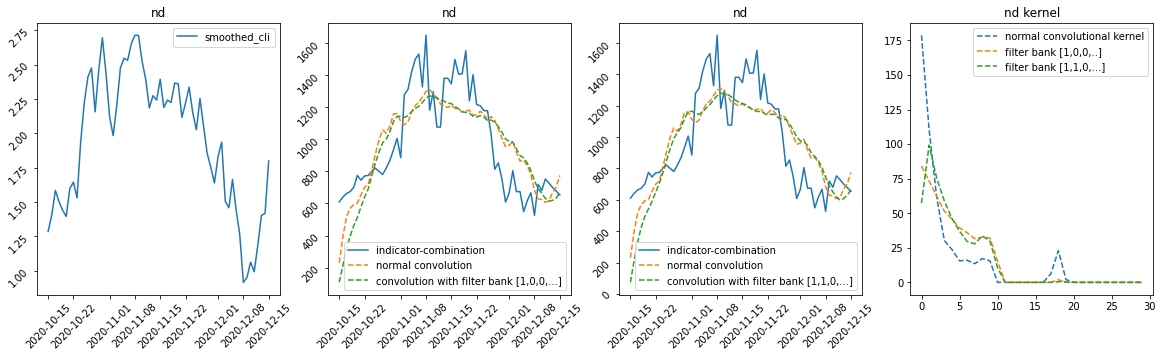

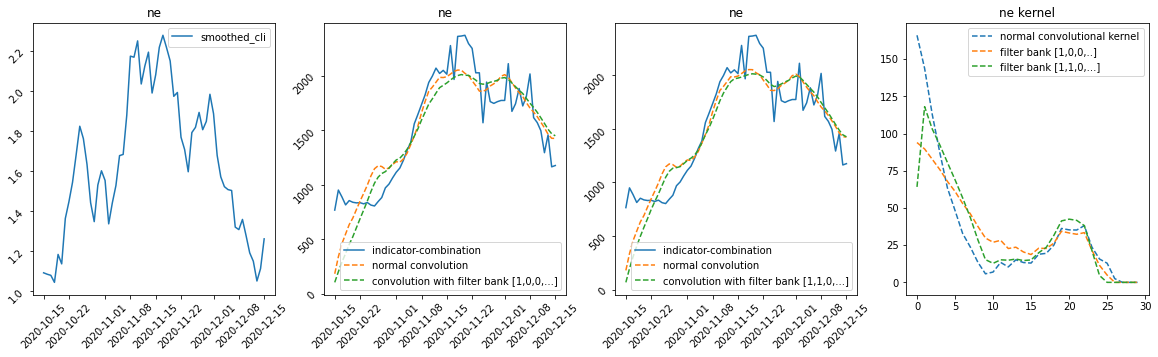

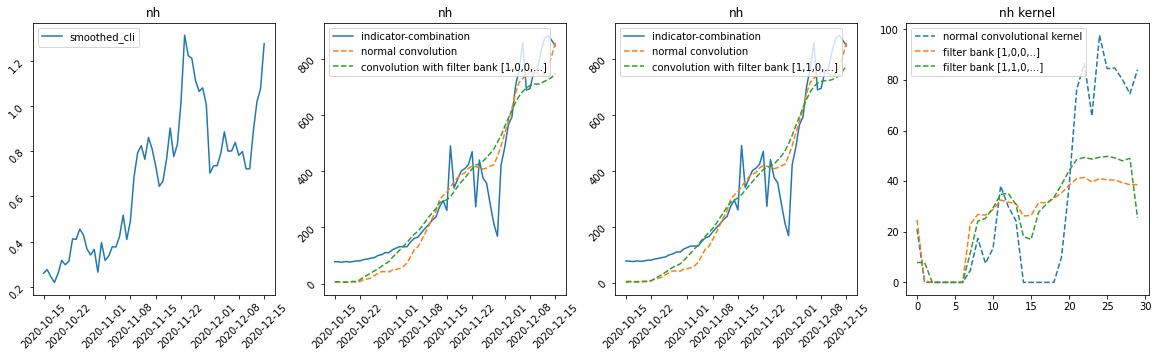

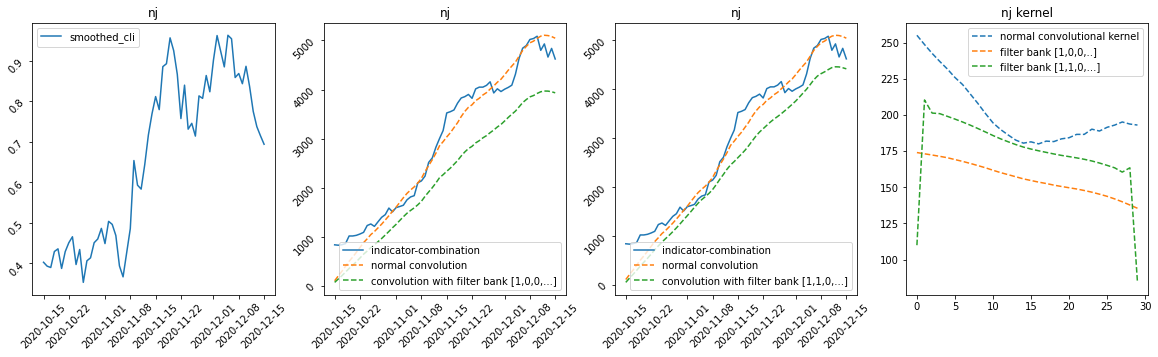

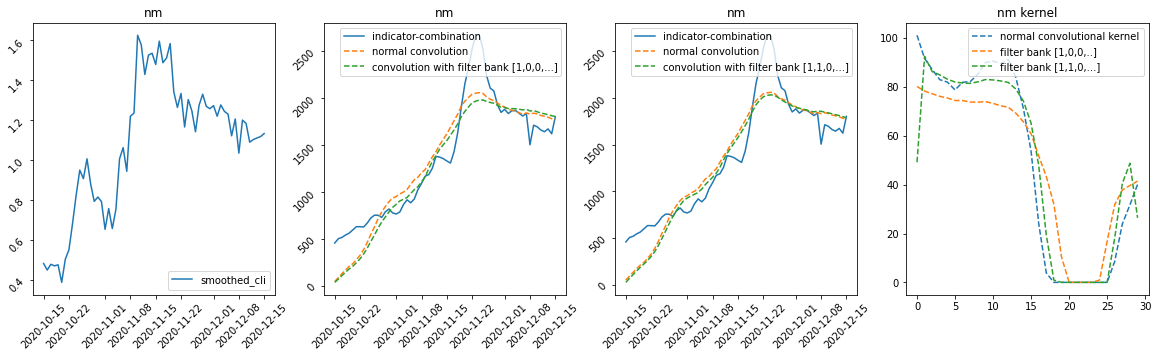

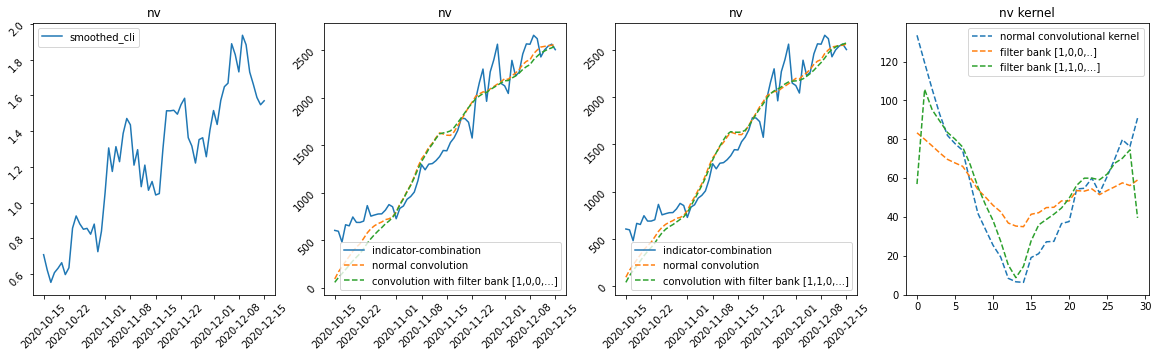

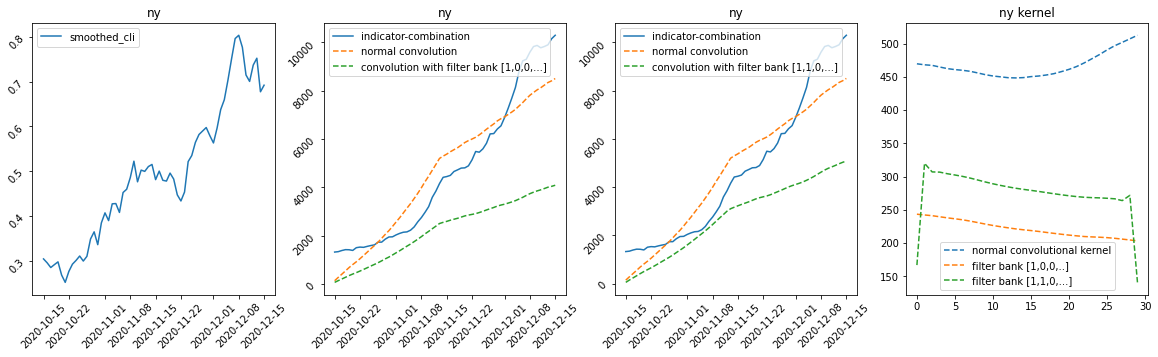

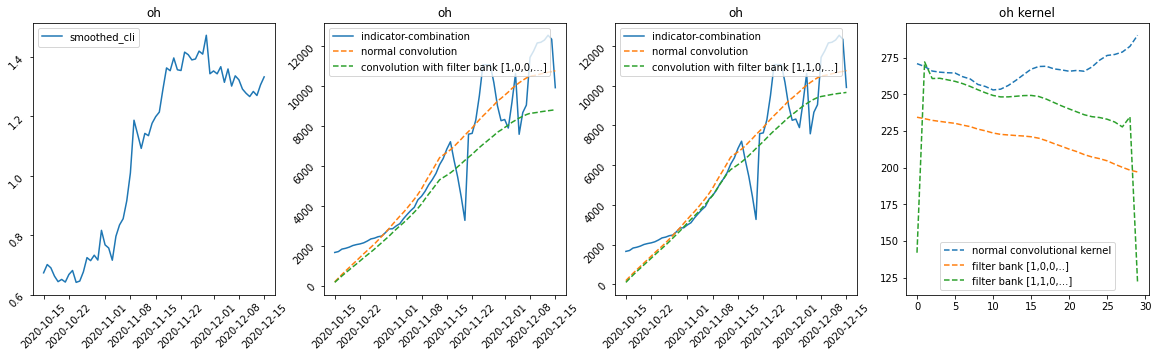

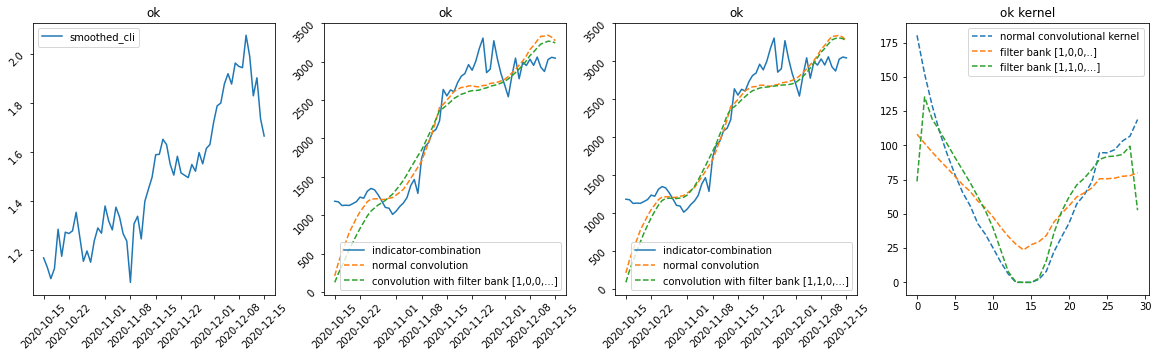

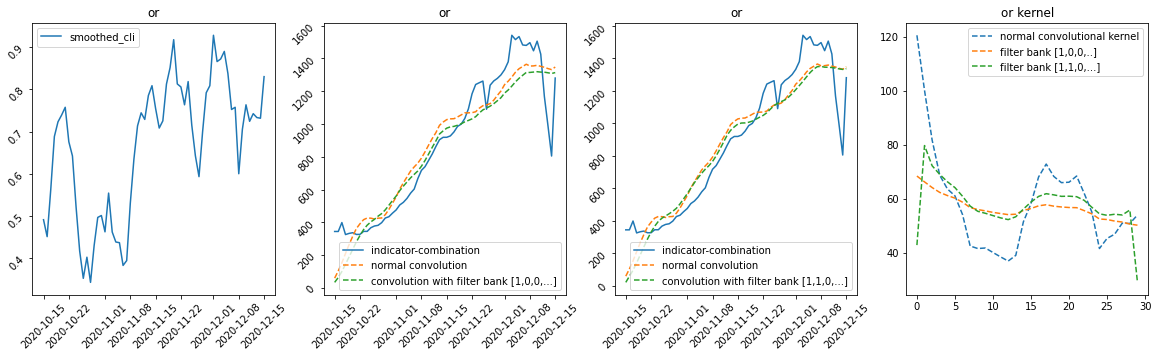

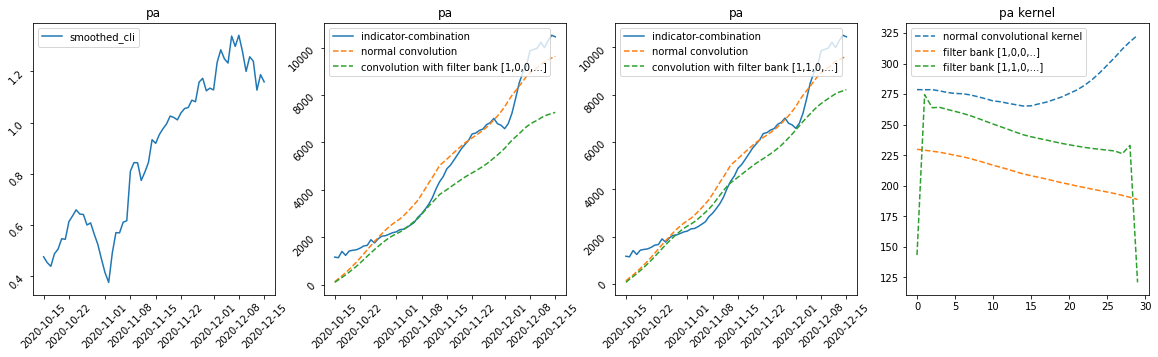

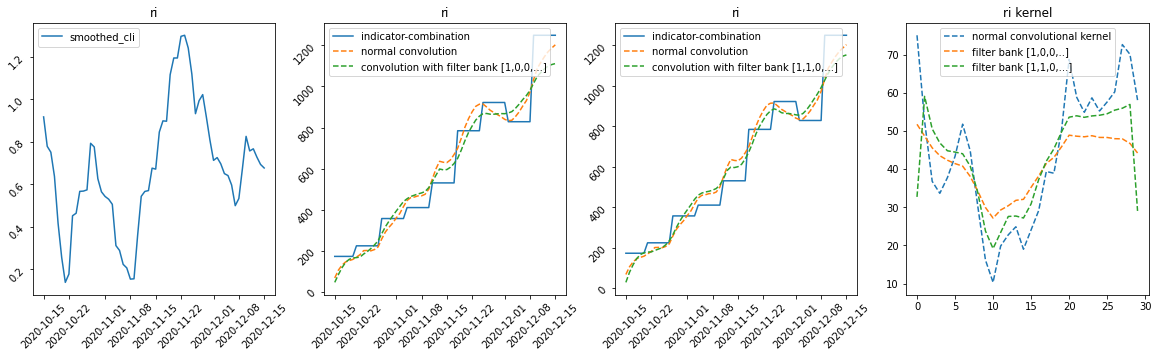

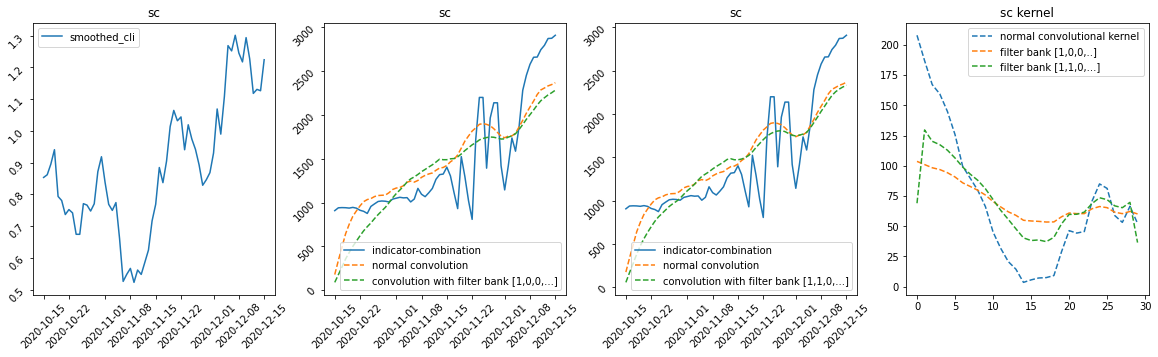

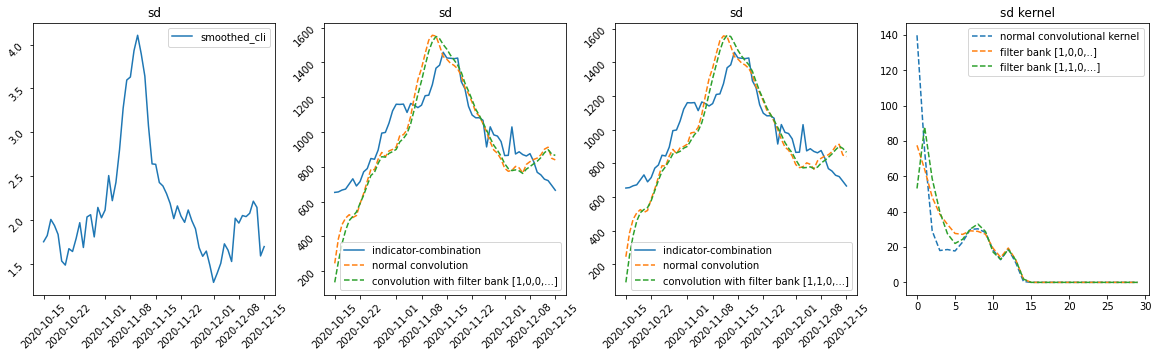

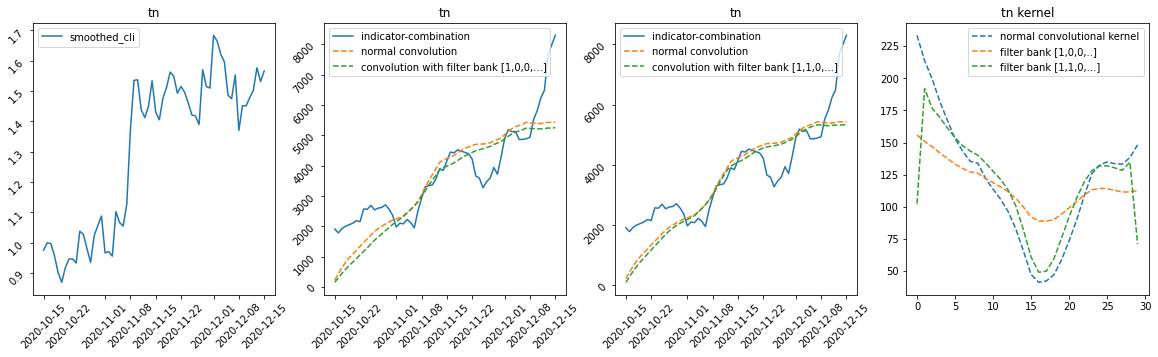

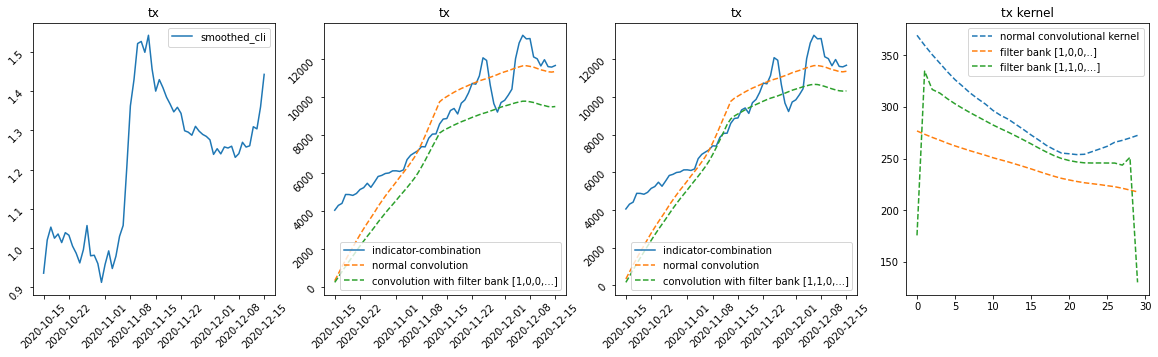

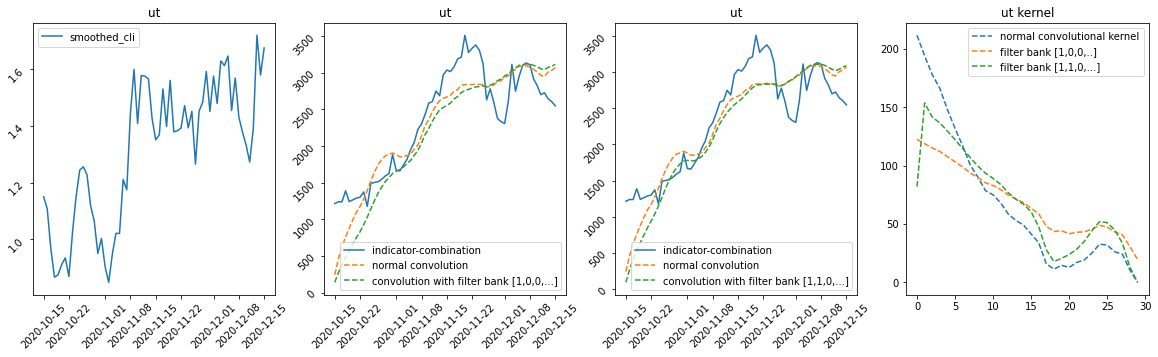

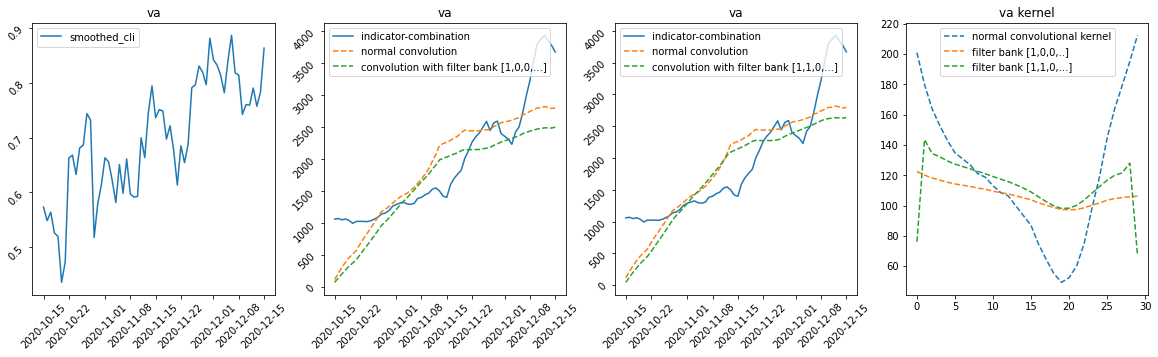

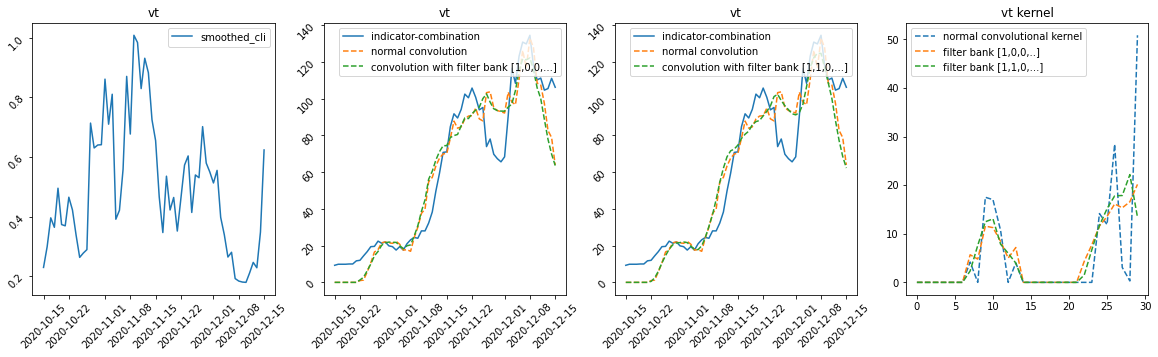

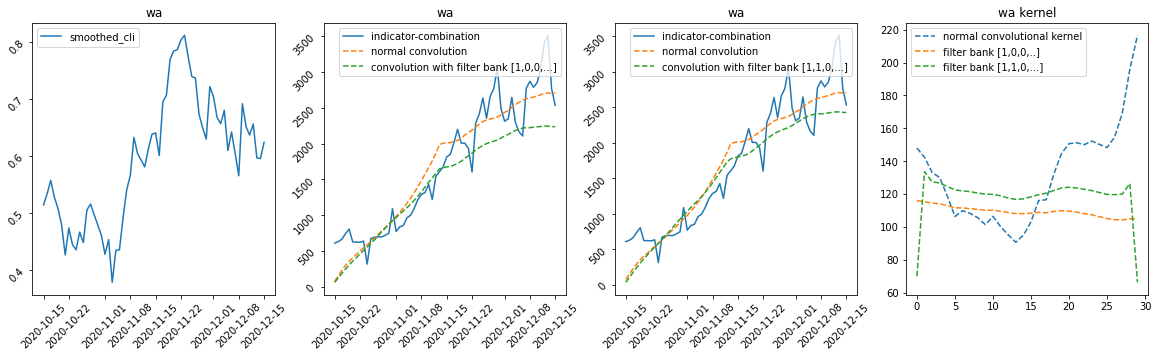

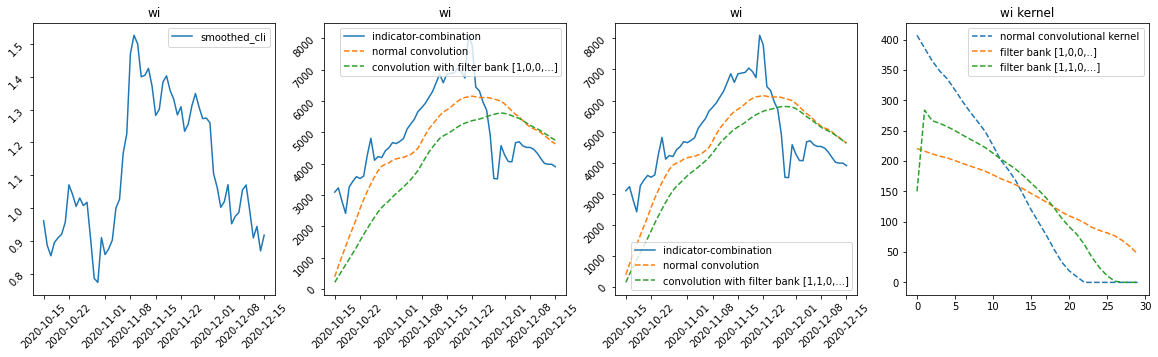

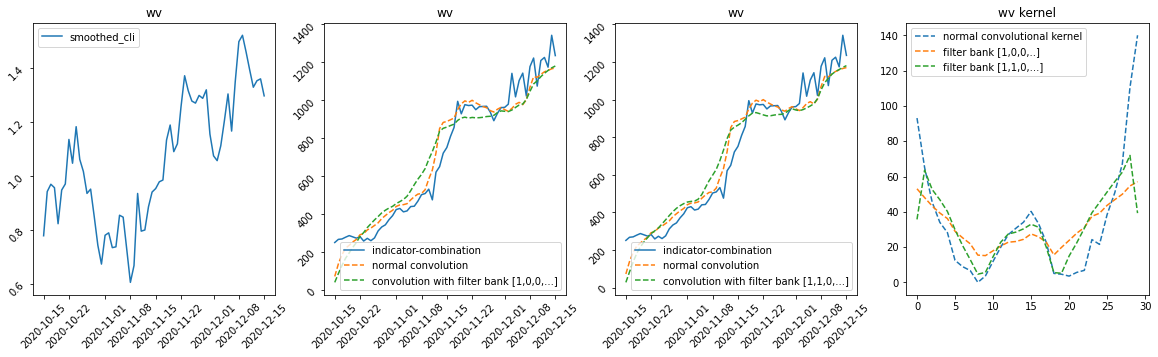

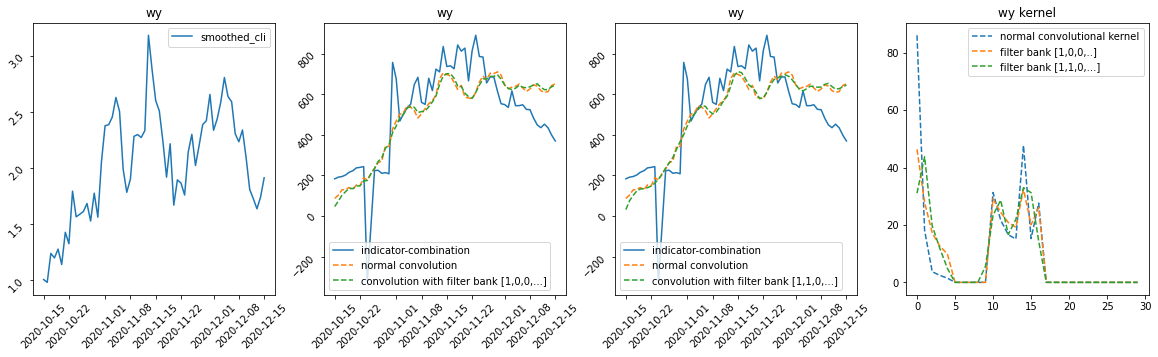

In [11]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training
model_b.load_weights(MODEL_B_PATH).expect_partial() #load best weights from training
model_c.load_weights(MODEL_C_PATH).expect_partial()

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)
Y_hat_model_b = model_b(X_padded)
Y_hat_model_c = model_c(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    y_hat_model_b = Y_hat_model_b[0,:,i]
    y_hat_model_c = Y_hat_model_c[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    ax[2].plot(dates, y, label='indicator-combination')
    ax[2].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[2].plot(dates, y_hat_model_c, label='convolution with filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{}'.format(states[i]))
    ax[2].tick_params(labelrotation=45)
    
    ax[3].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[3].plot(get_kernel(model_b,i)[::-1], label='filter bank [1,0,0,..]', linestyle='--')
    ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[3].legend()
    ax[3].set_title('{} kernel'.format(states[i]))
    
    plt.show()